To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

**[NEW] Llama-3 8b is trained on a crazy 15 trillion tokens! Llama-2 was 2 trillion.**

Use our [Llama-3 8b Instruct](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing) notebook for conversational style finetunes.

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
import sys
from pathlib import Path

workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /home/inflaton/code/projects/courses


In [23]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: 


False

In [24]:
import os

model_name = os.getenv("MODEL_NAME") or "Qwen/Qwen2-7B"
token = os.getenv("HF_TOKEN") or None
load_in_4bit = os.getenv("LOAD_IN_4BIT") == "true"
local_model = os.getenv("LOCAL_MODEL")
hub_model = os.getenv("HUB_MODEL")
num_train_epochs = int(os.getenv("NUM_TRAIN_EPOCHS") or 0)
results_path = os.getenv("RESULTS_PATH")

max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = (
    None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
)


model_name, load_in_4bit, local_model, hub_model, max_seq_length, num_train_epochs, dtype, results_path

('unsloth/Phi-3-mini-4k-instruct-bnb-4bit',
 True,
 'models/Phi-3-mini-4k-instruct-bnb-4bit-MAC-',
 'Phi-3-mini-4k-instruct-bnb-4bit-',
 2048,
 10,
 None,
 'results/mac-results.csv')

In [25]:
import pandas as pd
from datasets import load_dataset

print("loading result file")
datasets = load_dataset("csv", data_files={"results": results_path})
datasets

loading result file


FileNotFoundError: Unable to find '/home/inflaton/code/projects/courses/results/mac-results.csv'

In [ ]:
df = datasets["results"].to_pandas()

In [ ]:
df.iloc[1001].to_list()

[1001,
 '停了一会儿，他突然问道：康明逊是孩子的父亲吧？',
 "After a long silence, he suddenly asked, 'Kang Mingxun is the father, isn't he?'",
 'After a pause, he asked, Was Kang Mingxun the father of the boy?',
 'A few seconds later, he asked suddenly: Is Kang Mingxun the father of the child?',
 "After a while, he suddenly asked, 'Kang Mingxun is the father of your child, right?'"]

In [ ]:
df.columns

Index(['index', 'chinese', 'english', 'unsloth/Qwen2-0.5B-Instruct(finetuned)',
       'unsloth/Qwen2-1.5B-Instruct',
       'unsloth/Qwen2-1.5B-Instruct(finetuned)'],
      dtype='object')

In [ ]:
from translation_engine import *

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


[nltk_data] Downloading package wordnet to /home/inflaton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/inflaton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/inflaton/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df.columns.T

Index(['index', 'chinese', 'english', 'unsloth/Qwen2-0.5B-Instruct(finetuned)',
       'unsloth/Qwen2-1.5B-Instruct',
       'unsloth/Qwen2-1.5B-Instruct(finetuned)'],
      dtype='object')

In [ ]:
metrics_df = pd.DataFrame(df.columns.T)[4:]
# metrics_df.reset_index(inplace=True)
metrics_df

,0
4,unsloth/Qwen2-1.5B-Instruct
5,unsloth/Qwen2-1.5B-Instruct(finetuned)


In [ ]:
metrics_df.rename(columns={0: "model"}, inplace=True)

In [ ]:
metrics_df.columns

Index(['model'], dtype='object')

In [ ]:
metrics_df.head()

,model
4,unsloth/Qwen2-1.5B-Instruct
5,unsloth/Qwen2-1.5B-Instruct(finetuned)


In [ ]:
metrics_df.reset_index(inplace=True)
metrics_df = metrics_df.drop(columns=["index"])
metrics_df

,model
0,unsloth/Qwen2-1.5B-Instruct
1,unsloth/Qwen2-1.5B-Instruct(finetuned)


In [ ]:
accuracy = []
meteor = []
bleu_1 = []
rouge_l = []
all_metrics = []
for col in df.columns[4:]:
    metrics = calc_metrics(df["english"], df[col], debug=True)
    print(f"{col}: {metrics}")
    
    accuracy.append(metrics["accuracy"])
    meteor.append(metrics["meteor"])
    bleu_1.append(metrics["bleu_scores"]["bleu"])
    rouge_l.append(metrics["rouge_scores"]["rougeL"])
    all_metrics.append(metrics)

metrics_df["accuracy"] = accuracy
metrics_df["meteor"] = meteor
metrics_df["bleu_1"] = bleu_1
metrics_df["rouge_l"] = rouge_l
metrics_df["all_metrics"] = all_metrics

unsloth/Qwen2-1.5B-Instruct: {'accuracy': 0.00176522506619594, 'correct_ids': [658, 659], 'meteor': 0.33552118264217856, 'bleu_scores': {'bleu': 0.08285381577653864, 'precisions': [0.40636974021865224, 0.12583290620194773, 0.051405438435685916, 0.02290685609386224], 'brevity_penalty': 0.9405675222192741, 'length_ratio': 0.9422656508777741, 'translation_length': 28447, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.38790464213835263, 'rouge2': 0.14138097890296358, 'rougeL': 0.32844359570702664, 'rougeLsum': 0.32814305183232095}}
unsloth/Qwen2-1.5B-Instruct(finetuned): {'accuracy': 0.00264783759929391, 'correct_ids': [147, 170, 194], 'meteor': 0.35503843183028994, 'bleu_scores': {'bleu': 0.09734851870184895, 'precisions': [0.38486636126948554, 0.12903115371448134, 0.05879839025606325, 0.030757244091566802], 'brevity_penalty': 1.0, 'length_ratio': 1.0050679032792316, 'translation_length': 30343, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.3808844368241341, 'rouge2':

In [ ]:
metrics_df.describe()

,accuracy,meteor,bleu_1,rouge_l
count,2.000000,2.000000,2.000000,2.000000
mean,0.002207,0.345280,0.090101,0.325973
std,0.000624,0.013801,0.010249,0.003494
min,0.001765,0.335521,0.082854,0.323503
25%,0.001986,0.340400,0.086477,0.324738
50%,0.002207,0.345280,0.090101,0.325973
75%,0.002427,0.350159,0.093725,0.327208
max,0.002648,0.355038,0.097349,0.328444


In [ ]:
metrics_df

,model,accuracy,meteor,bleu_1,rouge_l,all_metrics
0,unsloth/Qwen2-1.5B-Instruct,0.001765,0.335521,0.082854,0.328444,"{'accuracy': 0.00176522506619594, 'correct_ids..."
1,unsloth/Qwen2-1.5B-Instruct(finetuned),0.002648,0.355038,0.097349,0.323503,"{'accuracy': 0.00264783759929391, 'correct_ids..."


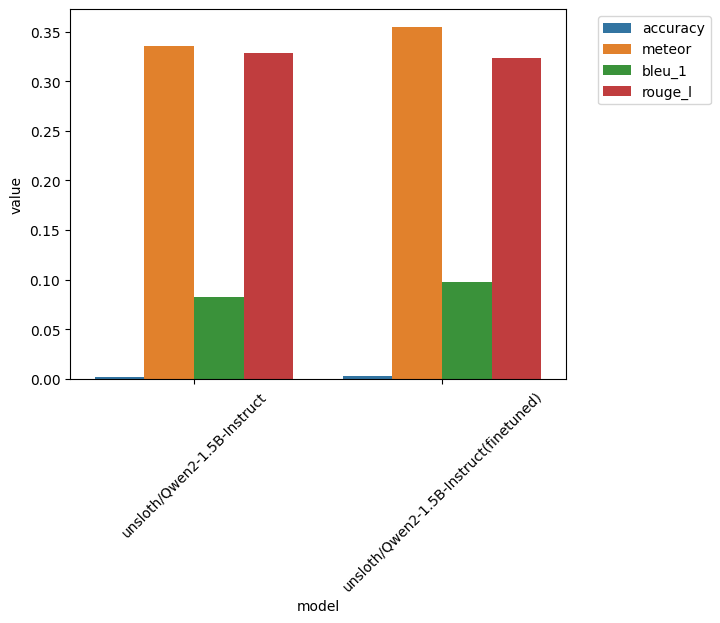

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame and 'category', 'value1', 'value2', 'value3' are columns in `df`
df_melted = pd.melt(
    metrics_df, id_vars="model", value_vars=["accuracy", "meteor", "bleu_1", "rouge_l"]
)

sns.barplot(x="model", y="value", hue="variable", data=df_melted)

plt.xticks(rotation=45)  # Rotate labels by 45 degrees

# Move the legend to an empty part of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

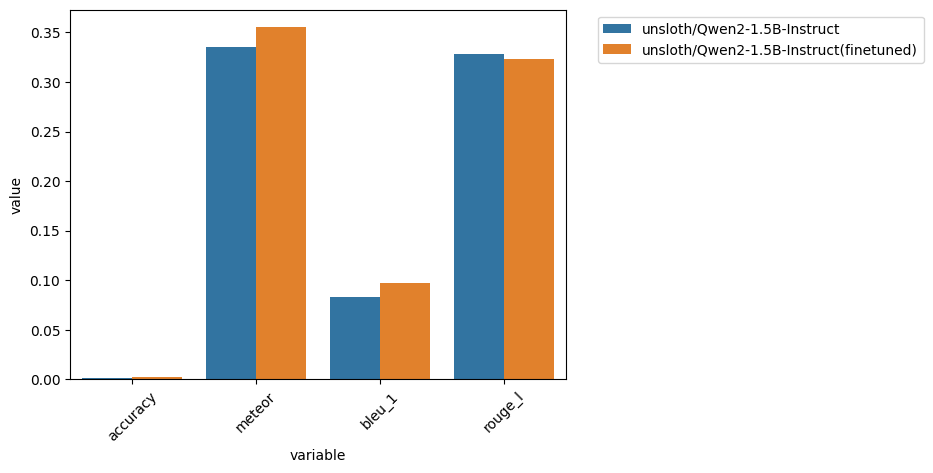

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame and 'model', 'accuracy', 'meteor', 'bleu_1', 'rouge_l' are columns in `df`
df_melted = pd.melt(
    metrics_df, id_vars="model", value_vars=["accuracy", "meteor", "bleu_1", "rouge_l"]
)

sns.barplot(x="variable", y="value", hue="model", data=df_melted)

plt.xticks(rotation=45)  # Rotate labels by 45 degrees

# Move the legend to an empty part of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()